# Sharks and ice cream

A confounding variable can induce association between variables that are not causally linked. To tackle this problem, **you have to control for all confounders**, that is, include them in your model.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plot_style import line_params, scatter_params

### Define the simulation mechanism

The variables here are: ice cream sales, shark attacks, and temperature.

We assume the causal structure: temperature affects ice cream (TEMP → ICE), and temperature affects shark attacks (TEMP → SHARK).

Correlation between variables = 0.801. Very high!


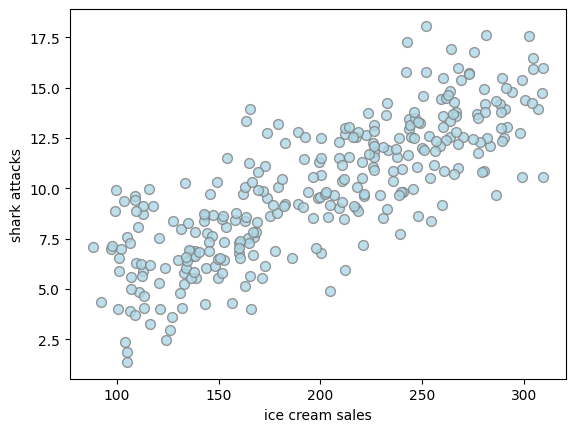

In [3]:
np.random.seed(42)
n = 300

# Temperature is indedependent and influences both variables
temp = np.random.uniform(10, 30, size=n)  # Temperature in degrees Celsius
ice_sales = 10 * temp + np.random.normal(0, 10, size=n)
shark_attacks = 0.5 * temp + np.random.normal(0, 2, size=n)

df = pd.DataFrame({"temp": temp, "ice_sales": ice_sales, "shark_attacks": shark_attacks})

# Scatter plot: ice_sales vs. shark_attacks with naive regression line
plt.scatter(df["ice_sales"], df["shark_attacks"], **scatter_params)
plt.xlabel("ice cream sales")
plt.ylabel("shark attacks")

# Naive correlation between ice cream sales and shark attacks
corr = df["ice_sales"].corr(df["shark_attacks"])
print(f"Correlation between variables = {corr:.3f}. Very high!")

### Train model 1

The first model predicts *shark_attacks* from *ice_sales*


Naive regression (shark_attacks ~ ice_sales):
                            OLS Regression Results                            
Dep. Variable:          shark_attacks   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     534.0
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           2.09e-68
Time:                        07:17:17   Log-Likelihood:                -637.45
No. Observations:                 300   AIC:                             1279.
Df Residuals:                     298   BIC:                             1286.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

Text(0, 0.5, 'shark attacks')

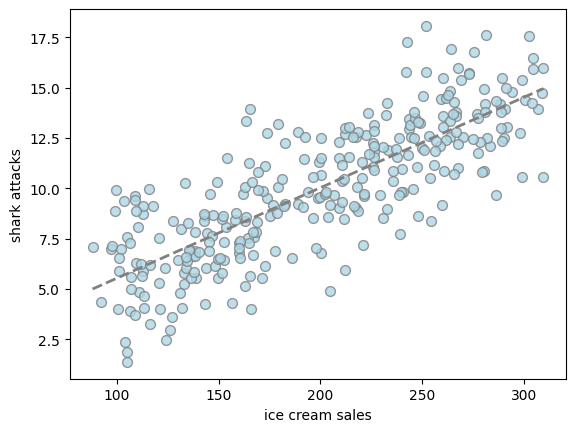

In [ ]:
# Naive regression
X1 = sm.add_constant(df['ice_sales'])
model1 = sm.OLS(df['shark_attacks'], X1).fit()

print("\nNaive regression (shark_attacks ~ ice_sales):")
print(model1.summary())

x_vals = np.linspace(df["ice_sales"].min(), df["ice_sales"].max(), 100)
y_vals = model1.params['const'] + model1.params["ice_sales"] * x_vals
plt.plot(x_vals, y_vals, **line_params)
plt.scatter(df["ice_sales"], df["shark_attacks"], **scatter_params)
plt.xlabel("ice cream sales")
plt.ylabel("shark attacks")

### Train model 2

The second model predicts *shark_attacks* from *ice_sales* and *temperature*


Regression (shark_attacks ~ ice_sales, temp):
                            OLS Regression Results                            
Dep. Variable:          shark_attacks   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     291.0
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           1.06e-70
Time:                        07:32:23   Log-Likelihood:                -628.71
No. Observations:                 300   AIC:                             1263.
Df Residuals:                     297   BIC:                             1275.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

Text(0.5, 0, 'shark attacks')

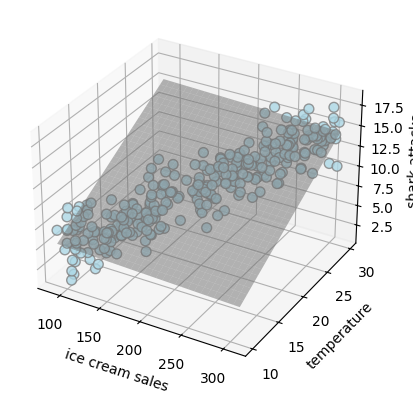

In [ ]:
# Fit linear model
X2 = sm.add_constant(df[["ice_sales", "temp"]])
model2 = sm.OLS(df["shark_attacks"], X2).fit()

print("\nRegression (shark_attacks ~ ice_sales, temp):")
print(model2.summary())

# Prepare grid for regression plane
ice_grid, temp_grid = np.meshgrid(
    np.linspace(df["ice_sales"].min(), df["ice_sales"].max(), 30),
    np.linspace(df["temp"].min(), df["temp"].max(), 30),
)
shark_pred = (
    model2.params["const"]
    + model2.params["ice_sales"] * ice_grid
    + model2.params["temp"] * temp_grid
)

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df["ice_sales"],
    df["temp"],
    df["shark_attacks"],
    **scatter_params
)
ax.plot_surface(ice_grid, temp_grid, shark_pred, color="gray", alpha=0.5)
ax.set_xlabel("ice cream sales")
ax.set_ylabel("temperature")
ax.set_zlabel("shark attacks")


### Visualize fit in 3D

(Doesn't render on a browser, but it's a cool visual)

In [ ]:
import plotly.graph_objs as go

# Scatter points
scatter = go.Scatter3d(
    x=df["ice_sales"],
    y=df["temp"],
    z=df["shark_attacks"],
    mode="markers",
    marker=dict(size=4, color="lightblue", line=dict(width=0.5, color="gray")),
    name="Data",
)

# Regression plane
surface = go.Surface(
    x=ice_grid,
    y=temp_grid,
    z=shark_pred,
    opacity=0.5,
    colorscale="Greys",
    name="Regression Plane",
    showscale=False,
)

fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    scene=dict(
        xaxis_title="ice cream sales", yaxis_title="temperature", zaxis_title="shark attacks"
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

### Check residual model

Train a model on the residuals

                            OLS Regression Results                            
Dep. Variable:              res_shark   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.08246
Date:                Tue, 26 Aug 2025   Prob (F-statistic):              0.774
Time:                        07:36:36   Log-Likelihood:                -628.71
No. Observations:                 300   AIC:                             1261.
Df Residuals:                     298   BIC:                             1269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.536e-15      0.114  -6.61e-14      1.0

Text(0.5, 1.0, 'including temperature')

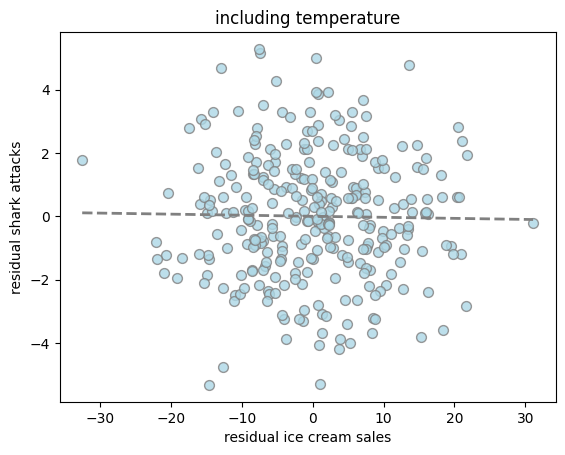

In [ ]:
# 5. Partial regression plot: residuals after removing temperature effect
ice_model = sm.OLS(df['ice_sales'], sm.add_constant(df['temp'])).fit()
shark_model = sm.OLS(df['shark_attacks'], sm.add_constant(df['temp'])).fit()
res_ice = pd.Series(ice_model.resid, name='res_ice')
res_shark = pd.Series(shark_model.resid, name='res_shark')
res_df = pd.DataFrame({'res_ice': res_ice, 'res_shark': res_shark})

# Fit regression on residuals
partial_model = sm.OLS(res_df['res_shark'], sm.add_constant(res_df['res_ice'])).fit()
print(partial_model.summary())

plt.figure()
plt.scatter(res_df['res_ice'], res_df['res_shark'], **scatter_params)
x_vals2 = np.linspace(res_df['res_ice'].min(), res_df['res_ice'].max(), 100)
y_vals2 = partial_model.params['const'] + partial_model.params['res_ice'] * x_vals2
plt.plot(x_vals2, y_vals2, **line_params)
plt.xlabel('residual ice cream sales')
plt.ylabel('residual shark attacks')
plt.title('including temperature')

### Conclusion

We know ice cream sales have nothing to do with shark attack rates... but training a model on these two variables will suggest there is! 🦈🍨

Next time you train a model and want to use it to make better decisions, be careful. If your goal is to change X to affect Y, **make sure you didn't forget to include any confounders in your analysis**.